##Импорт библиотек

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [49]:
import tensorflow as tf
from tensorflow import keras
import pathlib
from pathlib import Path
import os
import natsort
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from tensorflow.keras.applications import VGG16

In [50]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    tf.config.experimental.set_memory_growth(gpus[0],True)

##Проверяем датасеты

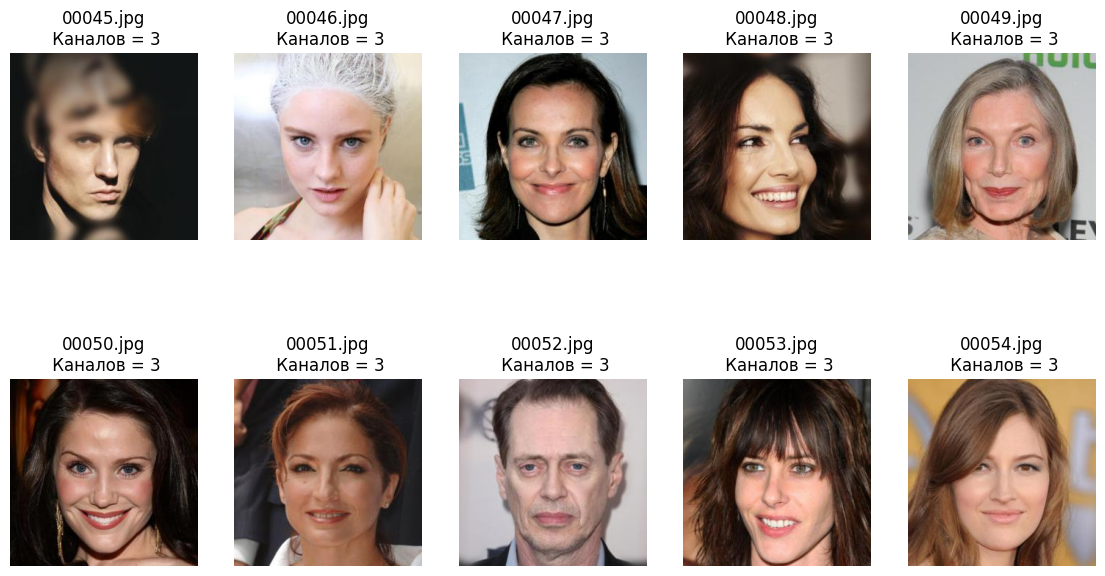

In [51]:
# Получим и отсортируем список с draw
draw_path = 'C:/Users/LazSa/Downloads/dataset/dataset/draw'
draw_filenames = natsort.natsorted(os.listdir(draw_path))

# Получим и отсортируем список с generate
generate_path = 'C:/Users/LazSa/Downloads/dataset/dataset/generate'
generate_filenames = natsort.natsorted(os.listdir(generate_path))

 # Получим и отсортируем список с photo
photo_path = 'C:/Users/LazSa/Downloads/dataset/dataset/photo'
photo_filenames = natsort.natsorted(os.listdir(photo_path))

#1. создаем график(фигуру) для вывода всех фото
pic_box = plt.figure(figsize=(14,12))
for i, image_name in enumerate(photo_filenames[5:15]):
    #2. считываем текущее изображение
    image = plt.imread(str(Path(photo_path, image_name)))
    #3. создаем "подграфик" для вывода текущего изображения в заданной позиции
    ax = pic_box.add_subplot(3,5,i+1)
    #4. в качестве названия графика определяем имя фотографии и число каналов
    ax.set_title(str(image_name) + '\n Каналов = ' + str(image.shape[2]))
    #5. выводим изображение на экран
    plt.imshow(image)
    #6. отключаем вывод осей графика
    plt.axis('off')
plt.show()

##Делим датасеты

In [52]:
import splitfolders
splitfolders.ratio('C:/Users/LazSa/Downloads/dataset/dataset', 'C:/Users/LazSa/Downloads/dataset/splited80', ratio=(0.8, 0.15, 0.05), seed=128, group_prefix=None)

Copying files: 30000 files [00:46, 648.76 files/s]


##Нормализация

Found 24000 images belonging to 3 classes.
Found 4500 images belonging to 3 classes.
Found 1500 images belonging to 3 classes.
Количество классов: 3


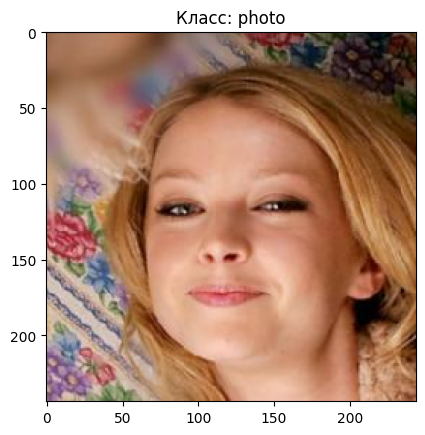

In [53]:
# определим параметры нормализации данных
train = ImageDataGenerator(rescale=1/255)
val = ImageDataGenerator(rescale=1/255)
test = ImageDataGenerator(rescale=1/255)

# сгенерируем нормализованные данные
train_data = train.flow_from_directory('C:/Users/LazSa/Downloads/dataset/splited80/train', target_size=(244,244),
                          class_mode='categorical', batch_size = 32, shuffle=True)
val_data = val.flow_from_directory('C:/Users/LazSa/Downloads/dataset/splited80/val', target_size=(244,244),
                                  class_mode='categorical', batch_size=32, shuffle=True)
test_data = test.flow_from_directory('C:/Users/LazSa/Downloads/dataset/splited80/test', target_size=(244,244),
                                      class_mode='categorical', batch_size = 32, shuffle=True)
classes = ['draw', 'generate', 'photo']

print("Количество классов:", len(train_data.class_indices))
sample_batch = next(train_data)  # Получим один батч
sample_image, sample_label = sample_batch[0][0], sample_batch[1][0]  # Извлечем изображение и метку
plt.imshow(sample_image)
plt.title(f"Класс: {classes[np.argmax(sample_label)]}")
plt.show()

##Используем VGG16

In [54]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(244, 244, 3))

# Заморозка слоев VGG16 для предотвращения их обучения
base_model.trainable = False

model = Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')
])

In [55]:
# Компиляция модели
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy', 'precision', 'recall', 'f1_score'])
# Файл для сохранения модели с лучшими параметрами
checkpoint_filepath = 'C:/Users/LazSa/Downloads/dataset/best_model.keras'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

## Тренировка модели

In [56]:
history = model.fit(train_data, validation_data=val_data, callbacks=[model_checkpoint_callback], batch_size=264, epochs=5, verbose=1)

C:\Users\LazSa\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 4001s 5s/step - accuracy: 0.8970 - f1_score: 0.8966 - loss: 0.4491 - precision: 0.8984 - recall: 0.8964 - val_accuracy: 0.9711 - val_f1_score: 0.9711 - val_loss: 0.0840 - val_precision: 0.9711 - val_recall: 0.9711
Epoch 2/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 3735s 5s/step - accuracy: 0.9652 - f1_score: 0.9651 - loss: 0.0954 - precision: 0.9657 - recall: 0.9650 - val_accuracy: 0.9776 - val_f1_score: 0.9776 - val_loss: 0.0650 - val_precision: 0.9778 - val_recall: 0.9776
Epoch 3/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 3725s 5s/step - accuracy: 0.9651 - f1_score: 0.9652 - loss: 0.0904 - precision: 0.9653 - recall: 0.9648 - val_accuracy: 0.9793 - val_f1_score: 0.9793 - val_loss: 0.0626 - val_precision: 0.9793 - val_recall: 0.9793
Epoch 4/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 3843s 5s/step - accuracy: 0.9748 - f1_score: 0.9748 - loss: 0.0693 - precision: 0.9753 - recall: 0.9743 - val_accuracy: 0.9822 - val_f1_score: 0.9822 - val_loss: 0.0511 - val_precision: 0.9822 - val_rec

#ROC AUC

##Validation data

Execution time: 0.00 seconds
Starting predictions on validation data...
141/141 ━━━━━━━━━━━━━━━━━━━━ 768s 5s/step
Predictions completed. Shape of y_pred: (4500, 3)
True labels extracted. Shape of y_true: (4500,)
True labels binarized. Shape of y_true: (4500, 3)
Predicted labels binarized. Shape of y_pred: (4500, 3)
Calculating ROC curve for class draw...
Class draw - ROC AUC: 0.51


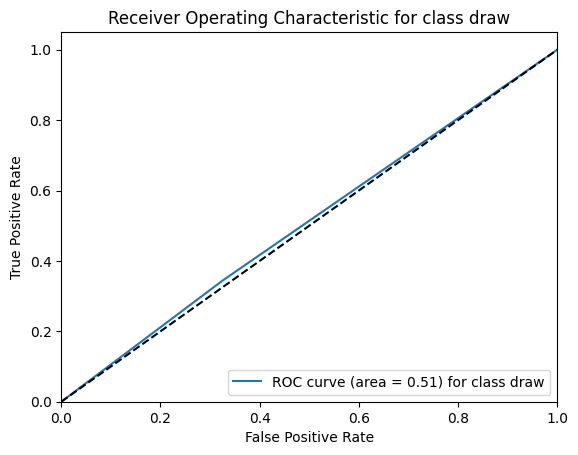

ROC curve plotted for class draw
Calculating ROC curve for class generate...
Class generate - ROC AUC: 0.52


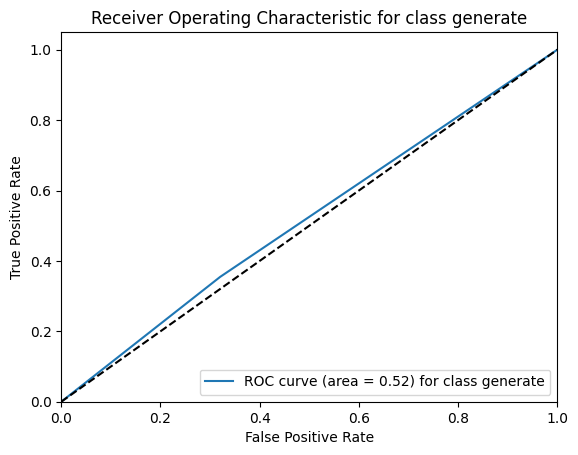

ROC curve plotted for class generate
Calculating ROC curve for class photo...
Class photo - ROC AUC: 0.51


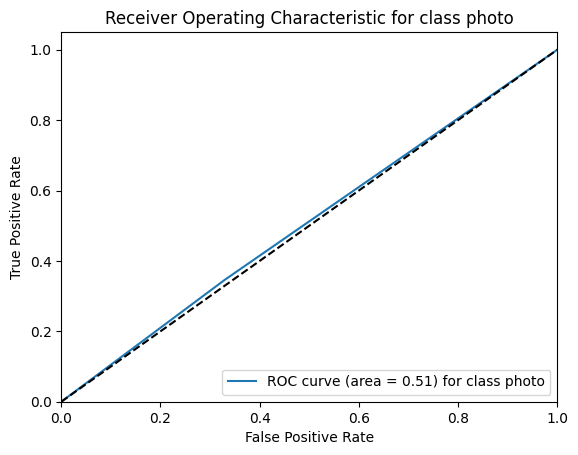

ROC curve plotted for class photo


In [57]:
import time
start_time = time.time()

# Определение классов
class_names = ['draw', 'generate', 'photo']

# Начало измерения времени
start_time = time.time()

# Шаги предсказания, обработки меток и построения кривых
print(f"Execution time: {time.time() - start_time:.2f} seconds")
print("Starting predictions on validation data...")

# Предсказания на валидационных данных
y_pred = model.predict(val_data)
print(f"Predictions completed. Shape of y_pred: {y_pred.shape}")

# Извлечение истинных меток из val_data
y_true = val_data.labels
print(f"True labels extracted. Shape of y_true: {y_true.shape}")

# Бинаризация истинных меток
y_true = label_binarize(y_true, classes=[0, 1, 2])
print(f"True labels binarized. Shape of y_true: {y_true.shape}")

# Бинаризация предсказанных меток
y_pred_class = np.argmax(y_pred, axis=-1)
y_pred = label_binarize(y_pred_class, classes=[0, 1, 2])
print(f"Predicted labels binarized. Shape of y_pred: {y_pred.shape}")

# Построение ROC-кривых для каждого класса
for i in range(3):
    print(f"Calculating ROC curve for class {class_names[i]}...")
    fpr, tpr, _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc = auc(fpr, tpr)
    print(f"Class {class_names[i]} - ROC AUC: {roc_auc:.2f}")

    # Построение графика
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f}) for class {class_names[i]}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic for class {class_names[i]}')
    plt.legend(loc="lower right")
    plt.show()
    print(f"ROC curve plotted for class {class_names[i]}")

##Test data

Execution time: 0.00 seconds
Starting predictions on validation data...


C:\Users\LazSa\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


47/47 ━━━━━━━━━━━━━━━━━━━━ 276s 6s/step
Predictions completed. Shape of y_pred: (1500, 3)
True labels extracted. Shape of y_true: (1500,)
True labels binarized. Shape of y_true: (1500, 3)
Predicted labels binarized. Shape of y_pred: (1500, 3)
Calculating ROC curve for class draw...
Class draw - ROC AUC: 0.50


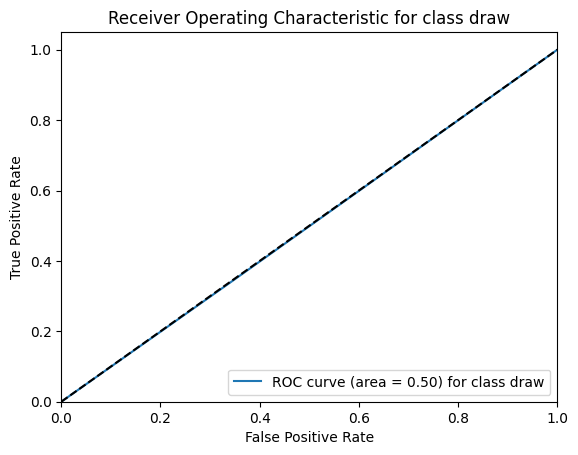

ROC curve plotted for class draw
Calculating ROC curve for class generate...
Class generate - ROC AUC: 0.52


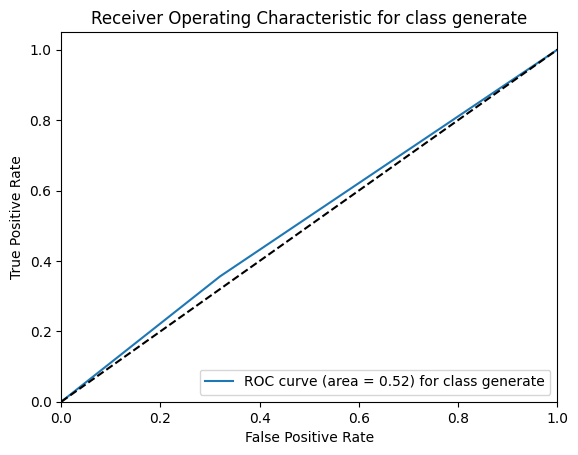

ROC curve plotted for class generate
Calculating ROC curve for class photo...
Class photo - ROC AUC: 0.52


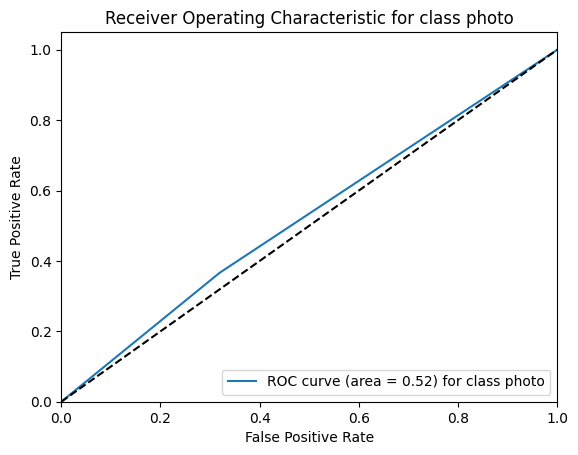

ROC curve plotted for class photo


In [58]:
# Определение классов
class_names = ['draw', 'generate', 'photo']

# Начало измерения времени
start_time = time.time()

# Шаги предсказания, обработки меток и построения кривых
print(f"Execution time: {time.time() - start_time:.2f} seconds")
print("Starting predictions on validation data...")

# Предсказания на валидационных данных
y_pred = model.predict(test_data)
print(f"Predictions completed. Shape of y_pred: {y_pred.shape}")

# Извлечение истинных меток из val_data
y_true = test_data.labels
print(f"True labels extracted. Shape of y_true: {y_true.shape}")

# Бинаризация истинных меток
y_true = label_binarize(y_true, classes=[0, 1, 2])
print(f"True labels binarized. Shape of y_true: {y_true.shape}")

# Бинаризация предсказанных меток
y_pred_class = np.argmax(y_pred, axis=-1)
y_pred = label_binarize(y_pred_class, classes=[0, 1, 2])
print(f"Predicted labels binarized. Shape of y_pred: {y_pred.shape}")

# Построение ROC-кривых для каждого класса
for i in range(3):
    print(f"Calculating ROC curve for class {class_names[i]}...")
    fpr, tpr, _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc = auc(fpr, tpr)
    print(f"Class {class_names[i]} - ROC AUC: {roc_auc:.2f}")

    # Построение графика
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f}) for class {class_names[i]}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic for class {class_names[i]}')
    plt.legend(loc="lower right")
    plt.show()
    print(f"ROC curve plotted for class {class_names[i]}")

# Графики метрик

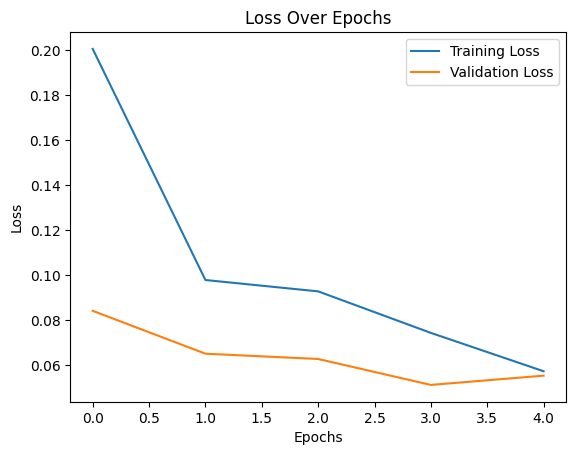

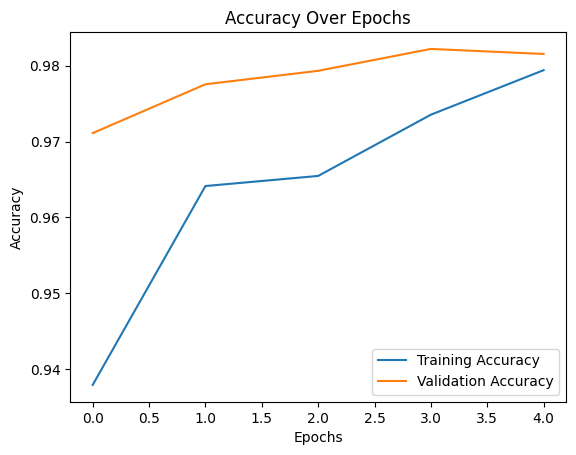

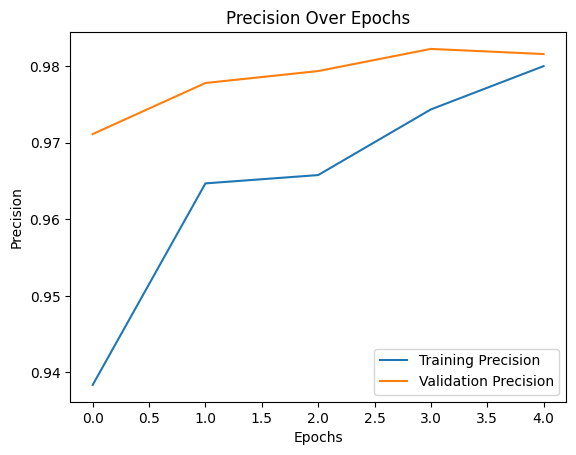

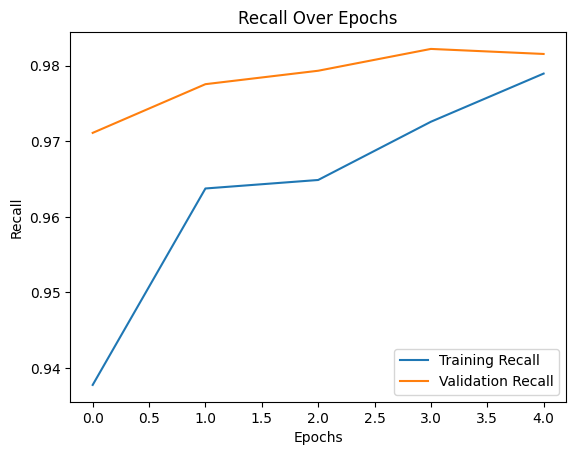

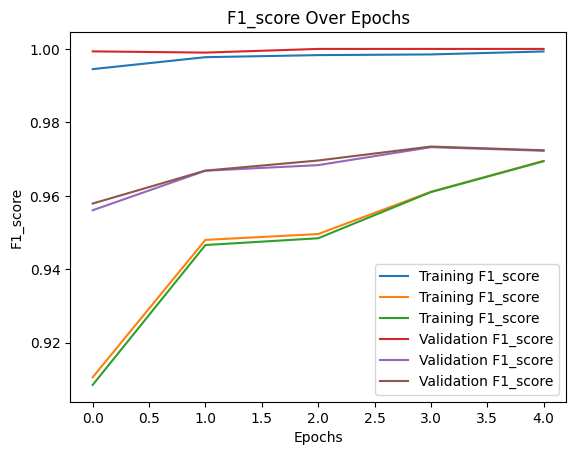

In [59]:
def plot_metrics(history):
    metrics = ['loss', 'accuracy', 'precision', 'recall', 'f1_score']
    for metric in metrics:
        plt.plot(history.history[metric], label=f'Training {metric.capitalize()}')
        plt.plot(history.history[f'val_{metric}'], label=f'Validation {metric.capitalize()}')
        plt.title(f'{metric.capitalize()} Over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel(metric.capitalize())
        plt.legend()
        plt.show()

plot_metrics(history)

#ConfusionMatrix

##Validation data

141/141 ━━━━━━━━━━━━━━━━━━━━ 663s 5s/step


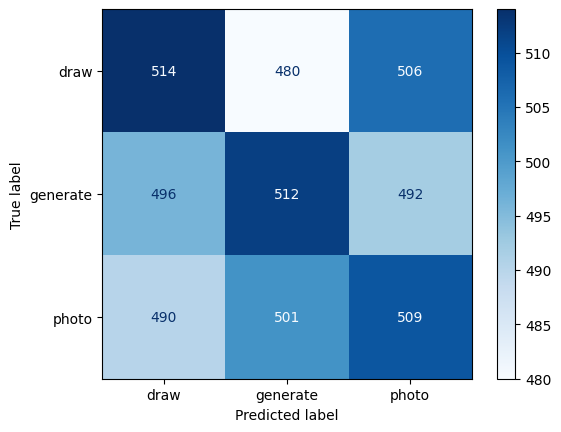

In [60]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Предсказания модели
y_pred = model.predict(val_data)
y_pred_classes = np.argmax(y_pred, axis=1)

# Истинные метки
y_true = val_data.classes

# Создание confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Визуализация
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=val_data.class_indices.keys())
disp.plot(cmap=plt.cm.Blues)
plt.show()


##Test data

47/47 ━━━━━━━━━━━━━━━━━━━━ 210s 4s/step


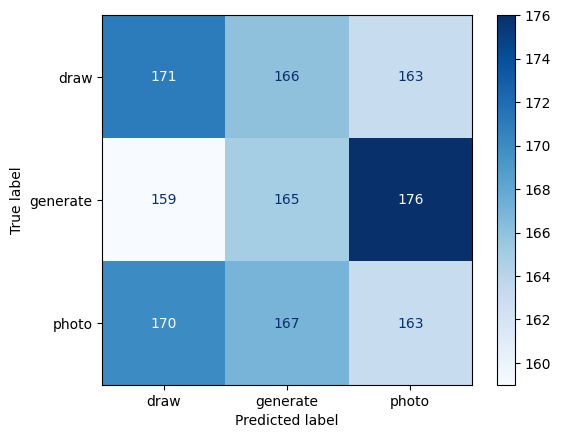

In [61]:
# Предсказания модели
y_pred = model.predict(test_data)
y_pred_classes = np.argmax(y_pred, axis=1)

# Истинные метки
y_true = test_data.classes

# Создание confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Визуализация
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=val_data.class_indices.keys())
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [63]:
model.save('C:/Users/LazSa/Downloads/Model1.keras')